In [1]:
%load_ext autoreload
%autoreload 2

## Prediction with the Single-Cell Model: Without Context vs CELTIC (With Context)

In this notebook, we demonstrate single-cell in silico labeling using two different models: 
1. The `U-Net` model without context.
2. The `CELTIC` model with context. 

We show the predictions for two cells - one in interphase and one in mitosis - using both models to illustrate the impact of context features on prediction performance.


### CELTIC installation

In [ ]:
# package installation (e.g for Colab users)
!git clone https://github.com/zaritskylab/CELTIC
%cd CELTIC
!pip install .

### Initializations

In [2]:
# set the absolute path to the CELTIC repo
REPO_ROOT = "/content/CELTIC"

# set the organelle (keep microtubules for this example)
organelle = 'microtubules' 

In [3]:
from celtic.predict import predict
import os
import pandas as pd
import numpy as np
import tifffile
from pathlib import Path
from celtic.utils.functions import show_images_subplots, initialize_experiment, download_example_files
import urllib.request

def plot_examples(path_save_dir):
    entries = [f'{path_save_dir}/{entry}' for entry in  sorted(os.listdir(path_save_dir))]
    dirs = [entry for entry in entries if os.path.isdir(entry)]
    images = []
    titles = []
    for dir in dirs:
        index = int(os.path.basename(dir))
        signal = tifffile.imread(f'{dir}/signal.tiff')
        target = tifffile.imread(f'{dir}/target.tiff')
        mask = tifffile.imread(f'{dir}/mask.tiff')
        prediction = np.squeeze(tifffile.imread(f'{dir}/prediction.tiff')) * mask
        z = signal.shape[0]//2
        images.extend([signal[z], target[z], prediction[z]])
        titles.extend([f'Signal ({index})', 'Target', 'Prediction'])
    show_images_subplots(shape=(len(dirs),3), images=images, titles=titles, axis_off=True, figsize=(15,8))


assert os.path.exists(REPO_ROOT) and REPO_ROOT.endswith("CELTIC"), "REPO_ROOT misconfiguration"

abs_path_resources_dir = Path(f'{REPO_ROOT}/resources/{organelle}') # location of the samples to be downloaded
path_single_cells = f'{abs_path_resources_dir}/cell_images'


### Download the demo samples

Download the test images and metadata (<2 min)

In [ ]:
download_example_files(abs_path_resources_dir, "predict")

Download the pretrained models

In [ ]:

model_repository = "https://huggingface.co/enitsan8/single-cell-microtubules-in-silico-labeling-unet-and-celtic/resolve/main"

models_dir = abs_path_resources_dir / "models"
models_dir.mkdir(parents=True, exist_ok=True)

model_paths = {
    "best_model_no_context.p": f"{model_repository}/best_model_no_context.p",
    "best_model_context.p": f"{model_repository}/best_model_context.p"
}

for filename, url in model_paths.items():
    destination = models_dir / filename
    if destination.exists():
        print(f"✅ Already exists: {filename}")
    else:
        print(f"⬇️ Downloading {filename}")
        urllib.request.urlretrieve(url, destination)
        print(f"✅ Saved to: {destination}")

### Run U-Net Prediction (Without Context)

In this section, we perform prediction using the a single cell model without incorporating context features. The experiment is initialized, and the necessary arguments are set up for the prediction process. The results are saved in the specified directory. This example shows predictions for two cells: one in interphase and the other in mitosis.

In the next section, we will perform prediction using context features for comparison.


In [9]:
# initialize the experiment
path_save_dir, context_model_config = initialize_experiment(organelle, 
                                                            'predict', 
                                                            models_dir=f'{abs_path_resources_dir}/models')
# prepare args and run prediction
args={
    'path_images_csv': f'{abs_path_resources_dir}/metadata/test_images.csv',
    'masked': True,
    'transforms': context_model_config['transforms'],
    'path_model': f'{abs_path_resources_dir}/models/best_model_no_context.p',
    'path_context_csv': '',
    'path_single_cells': path_single_cells,
    'context_features': [],
    'daft_embedding_factor': None,
    'daft_scale_activation': None,
    'path_save_dir': path_save_dir,
    'save_only_prediction': False,
    'selected_indices': [44, 45], # interphase and mitosis examples
    'evaluation_metrics': ['mse', 'pearsonr']
}

predict.run_prediction(**args)

100%|██████████| 2/2 [00:06<00:00,  3.32s/it]


After running the prediction, we load the evaluation results from the saved `evaluation.csv` file, in the experiment folder. The mean Pearson correlation coefficient (PCC) across all predictions is calculated and displayed. The full evaluation results, including individual cell predictions, are also printed for further analysis.

In [10]:
results = pd.read_csv(f'{path_save_dir}/evaluation.csv').sort_values(by='cell_index')
print(f'Mean PCC = {np.mean(results.pearsonr.values):.3f}')
results

Mean PCC = 0.630


,cell_index,mse,pearsonr
0,44,0.266257,0.856797
1,45,0.838720,0.402408


We visualize the predictions of the :
- interphase cell (example 44), and 
- mitotic cell (example 45).

The images include the bright field image, the target (ground truth), and the in silico prediction generated without context. 

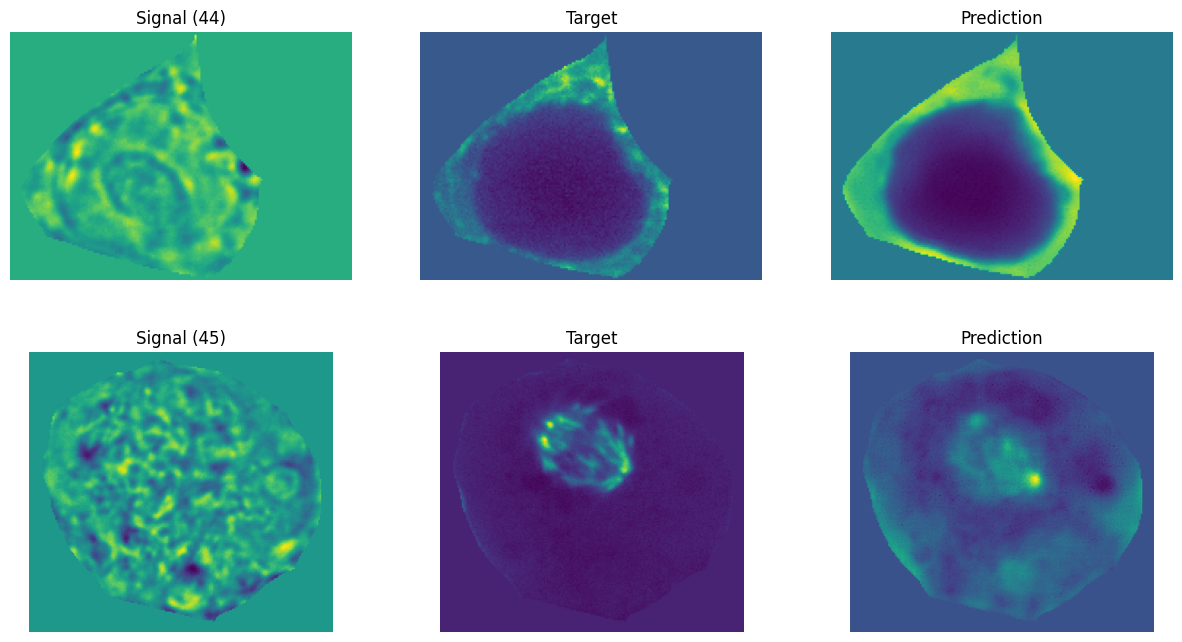

In [11]:
plot_examples(path_save_dir)

### Run CELTIC Prediction (With Context)

In this section, we repeat the prediction process for the same two cells (one in interphase and one in mitosis), but this time, we use the CELTIC model with context features. The experiment is initialized, and the necessary arguments are set up for prediction, incorporating the context data alongside the image inputs. 

This allows for a direct comparison with the previous predictions made without context.


In [13]:
# initialize another experiment
path_save_dir, context_model_config = initialize_experiment(organelle, 
                                                            'predict', 
                                                            models_dir=f'{abs_path_resources_dir}/models')
# prepare args and run prediction
args={
    'path_images_csv': f'{abs_path_resources_dir}/metadata/test_images.csv',
    'masked': True,
    'transforms': context_model_config['transforms'],
    'path_model': f'{abs_path_resources_dir}/models/best_model_context.p',
    'path_single_cells': path_single_cells,
    'path_context_csv': f'{abs_path_resources_dir}/metadata/test_context.csv',
    'context_features': context_model_config['context_features'],
    'daft_embedding_factor': context_model_config['daft_embedding_factor'],
    'daft_scale_activation': context_model_config['daft_scale_activation'],
    'path_save_dir': path_save_dir,
    'save_only_prediction': False,
    'selected_indices': [44, 45],# interphase and mitosis examples
    'evaluation_metrics': ['mse', 'pearsonr']   
}

predict.run_prediction(**args)

bottleneck_dim=132
embedding factor: 4 | activation: Sigmoid()


100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


In [14]:
results = pd.read_csv(f'{path_save_dir}/evaluation.csv').sort_values(by='cell_index')
print(f'Mean PCC = {np.mean(results.pearsonr.values):.3f}')
results

Mean PCC = 0.777


,cell_index,mse,pearsonr
0,44,0.330851,0.832458
1,45,0.536928,0.722344


**The mitotic cell (45) shows an increase in Pearson's correlation coefficient and is visually closer to the ground truth image.**

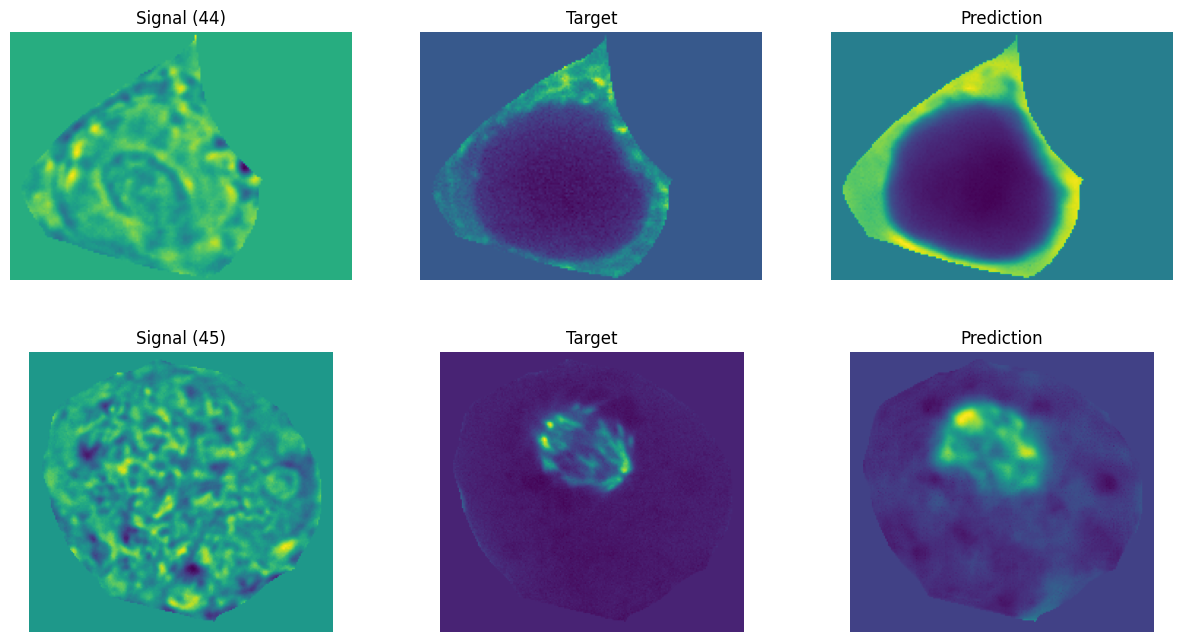

In [15]:
plot_examples(path_save_dir)